# Transformer - Attention is all you Need
Implementation of the non autoregressive seq2seq model - Transformer, outlined in [this](https://arxiv.org/abs/1706.03762) paper. Code is taken with minor changes from HarvardNLP's [implementation](https://github.com/harvardnlp/annotated-transformer) adapted for [CMU pronouncing dataset](http://www.speech.cs.cmu.edu/cgi-bin/cmudict).

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn 
%matplotlib inline

import pdb

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Model

In [3]:
class EncoderDecoder(nn.Module):

    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        return self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [4]:
class Generator(nn.Module):
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

### Layers

In [5]:
class Encoder(nn.Module):
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        #pdb.set_trace()
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [88]:
class Decoder(nn.Module):
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In [89]:
class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

In [8]:
class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, x, memory, src_mask, tgt_mask):
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

In [9]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

### Sub-Layer

In [10]:
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [11]:
class SublayerConnection(nn.Module):

    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

In [12]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

In [13]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

In [14]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

In [15]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [16]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

In [17]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

### Define Model

In [18]:
def make_model(src_vocab, tgt_vocab, N=6, 
               d_model=512, d_ff=2048, h=8, dropout=0.1):
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
    
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

## Training

### Batches and Masking

In [19]:
class Batch:
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = torch.tensor((src != pad).unsqueeze(-2)).to(device)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = torch.tensor(self.make_std_mask(self.trg, pad)).to(device)
            self.ntokens = (self.trg_y != pad).data.sum()
    
    @staticmethod
    def make_std_mask(tgt, pad):
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

### Training Loop

In [20]:
def run_epoch(data_iter, model, loss_compute, epoch):
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg, 
                            batch.src_mask, batch.trg_mask)
        #if (epoch) > 0:
        #    pdb.set_trace()
        loss = loss_compute(out, batch.trg_y, batch.ntokens, epoch)
        total_loss += loss
        total_tokens += batch.ntokens.item()
        tokens += batch.ntokens.item()
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (epoch, loss / batch.ntokens.float(), tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

### Optimizer

In [21]:

class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

### Label Smoothing

In [22]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target, epoch):
        #if epoch > 0:
         #   pdb.set_trace()
        assert x.size(1) == self.size
        true_dist = x.detach().clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.detach().unsqueeze(1), self.confidence)
        #true_dist[:, self.padding_idx] = 0
        #mask = torch.nonzero(target.detach() == self.padding_idx)
        #if mask.dim() > 1:
        #    true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, torch.tensor(true_dist, requires_grad=False))

### Loss

In [23]:
class SimpleLossCompute:
    "A simple loss compute and train function."
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm, epoch):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), 
                              y.contiguous().view(-1), epoch) / norm.item()
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.item() * norm.item()

## Loading Dataset 

In [24]:
import re
from sklearn.model_selection import train_test_split


In [25]:
Path = 'data/'

In [26]:
#Get each word that begins with A-Z from each line into a list 
lines = [l.strip().split("  ") for l in open(Path+'cmudict-0.7b', encoding='latin1') 
         if re.match('^[A-Z]', l)]
#Split words and phonemes
lines = [(w, ps.split()) for w, ps in lines]
lines[0]

('A', ['AH0'])

In [27]:
#Get a list of all the unique phonemes from lines and adding _ to position 0 because it corresponds to padding
#when tokenised
phonemes = ["_"]+sorted(set(p for w, ps in lines for p in ps))
len(phonemes)

70

In [28]:
#Map phonemes to indices and letters to indices.
p2i = dict((v, k) for k, v in enumerate(phonemes))
letters = "_*!abcdefghijklmnopqrstuvwxyz"
l2i = dict((v, k) for k, v in enumerate(letters))

In [29]:
maxlen = 15
#Map words to corresponding list of phoneme indices with constraints. 
pronounce_dict = {w.lower(): [p2i[p] for p in ps] for w, ps in lines
                    if (5<=len(w)<=maxlen) and re.match("^[A-Z]+$", w)}
len(pronounce_dict)

108006

In [30]:
maxlen_p = max([len(v) for k,v in pronounce_dict.items()]); maxlen_p

16

In [31]:
#words contain the number of words in the filtered dictionary
words = np.random.permutation(list(pronounce_dict.keys()))
n = len(words)

In [32]:
#Initialise the input and labels array with zeros so that everywhere except 
#the position of values is padded
input_ = np.zeros((n, maxlen_p), np.int32)
labels_ = np.zeros((n, maxlen+2), np.int32)

#Fill in the non zero indices
for i, k in enumerate(words):
    for j, p in enumerate(pronounce_dict[k]): 
        input_[i][j]=p
    labels_[i][0] = 1
    for j, p in enumerate(k): 
        labels_[i][j+1] = l2i[p]
    labels_[i][j+2]=2

In [33]:
#Create train, validation sets
(input_train, input_test, labels_train, labels_test, 
    ) = train_test_split(input_, labels_, test_size=0.1)

In [34]:
input_vocab_size, output_vocab_size = len(phonemes), len(letters);input_vocab_size, output_vocab_size

(70, 29)

In [35]:
def get_batch(x, y, nbatches, batch_size=64):
    for i in range(nbatches):
        #pdb.set_trace()
        idxs = np.random.permutation(len(x))[:batch_size]
        src = torch.tensor(x[idxs].astype('int64'), requires_grad=False).to(device)
        tgt = torch.tensor(y[idxs].astype('int64'), requires_grad=False).to(device)
        yield Batch(src, tgt, 0)

In [36]:
# Train the simple copy task.
criterion = LabelSmoothing(size=len(letters), padding_idx=0, smoothing=0.1).to(device)
model = make_model(len(phonemes), len(letters), N=6).to(device)
len(phonemes)
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 10000,
        torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

In [98]:
for epoch in range(10):
    model.train()
    run_epoch(get_batch(input_train, labels_train, 3374), model, 
              SimpleLossCompute(model.generator, criterion, model_opt), epoch)

Epoch Step: 0 Loss: 0.178106 Tokens per Sec: 5361.126843
Epoch Step: 0 Loss: 0.185459 Tokens per Sec: 6183.029656
Epoch Step: 0 Loss: 0.136132 Tokens per Sec: 6503.330557
Epoch Step: 0 Loss: 0.166231 Tokens per Sec: 6218.888548
Epoch Step: 0 Loss: 0.131396 Tokens per Sec: 6282.768536
Epoch Step: 0 Loss: 0.174808 Tokens per Sec: 6619.670707
Epoch Step: 0 Loss: 0.135695 Tokens per Sec: 6604.032474
Epoch Step: 0 Loss: 0.139221 Tokens per Sec: 6609.371566
Epoch Step: 0 Loss: 0.199629 Tokens per Sec: 6607.065747
Epoch Step: 0 Loss: 0.137356 Tokens per Sec: 6643.326426
Epoch Step: 0 Loss: 0.124332 Tokens per Sec: 6626.789705
Epoch Step: 0 Loss: 0.128992 Tokens per Sec: 6573.235966
Epoch Step: 0 Loss: 0.157706 Tokens per Sec: 6609.278005
Epoch Step: 0 Loss: 0.124835 Tokens per Sec: 6519.849467
Epoch Step: 0 Loss: 0.168470 Tokens per Sec: 6501.854276
Epoch Step: 0 Loss: 0.089740 Tokens per Sec: 6528.793412
Epoch Step: 0 Loss: 0.134573 Tokens per Sec: 6471.821086
Epoch Step: 0 Loss: 0.125553 To

Epoch Step: 2 Loss: 0.142724 Tokens per Sec: 6578.832536
Epoch Step: 2 Loss: 0.149819 Tokens per Sec: 6596.728045
Epoch Step: 2 Loss: 0.115471 Tokens per Sec: 6614.453962
Epoch Step: 2 Loss: 0.136102 Tokens per Sec: 6650.943257
Epoch Step: 2 Loss: 0.115964 Tokens per Sec: 6552.182006
Epoch Step: 2 Loss: 0.134324 Tokens per Sec: 6572.520112
Epoch Step: 2 Loss: 0.121140 Tokens per Sec: 6527.482087
Epoch Step: 2 Loss: 0.131238 Tokens per Sec: 6550.359719
Epoch Step: 2 Loss: 0.133756 Tokens per Sec: 6526.637093
Epoch Step: 2 Loss: 0.100677 Tokens per Sec: 6571.800937
Epoch Step: 2 Loss: 0.137473 Tokens per Sec: 6557.214872
Epoch Step: 2 Loss: 0.112952 Tokens per Sec: 6619.415460
Epoch Step: 2 Loss: 0.106698 Tokens per Sec: 6521.544209
Epoch Step: 2 Loss: 0.110055 Tokens per Sec: 6544.208444
Epoch Step: 2 Loss: 0.143878 Tokens per Sec: 6563.369596
Epoch Step: 2 Loss: 0.131977 Tokens per Sec: 6558.316720
Epoch Step: 2 Loss: 0.133492 Tokens per Sec: 6623.335548
Epoch Step: 2 Loss: 0.127011 To

Epoch Step: 4 Loss: 0.094953 Tokens per Sec: 6585.693554
Epoch Step: 4 Loss: 0.093782 Tokens per Sec: 6525.988925
Epoch Step: 4 Loss: 0.117538 Tokens per Sec: 6575.520300
Epoch Step: 4 Loss: 0.117433 Tokens per Sec: 6589.858546
Epoch Step: 4 Loss: 0.095431 Tokens per Sec: 6525.978500
Epoch Step: 4 Loss: 0.089180 Tokens per Sec: 6598.071408
Epoch Step: 4 Loss: 0.129687 Tokens per Sec: 6557.227044
Epoch Step: 4 Loss: 0.099603 Tokens per Sec: 6579.931369
Epoch Step: 4 Loss: 0.107368 Tokens per Sec: 6516.647263
Epoch Step: 4 Loss: 0.100297 Tokens per Sec: 6598.464682
Epoch Step: 4 Loss: 0.149595 Tokens per Sec: 6555.255020
Epoch Step: 4 Loss: 0.128163 Tokens per Sec: 6542.082957
Epoch Step: 4 Loss: 0.106122 Tokens per Sec: 6517.436940
Epoch Step: 4 Loss: 0.099257 Tokens per Sec: 6522.023510
Epoch Step: 4 Loss: 0.138490 Tokens per Sec: 6507.938689
Epoch Step: 4 Loss: 0.110766 Tokens per Sec: 6549.035387
Epoch Step: 4 Loss: 0.124394 Tokens per Sec: 6565.162837
Epoch Step: 4 Loss: 0.111893 To

Epoch Step: 6 Loss: 0.081543 Tokens per Sec: 6576.815451
Epoch Step: 6 Loss: 0.156271 Tokens per Sec: 6520.595801
Epoch Step: 6 Loss: 0.072967 Tokens per Sec: 6580.983451
Epoch Step: 6 Loss: 0.106676 Tokens per Sec: 6610.862633
Epoch Step: 6 Loss: 0.123762 Tokens per Sec: 6543.937735
Epoch Step: 6 Loss: 0.103203 Tokens per Sec: 6547.490710
Epoch Step: 6 Loss: 0.102655 Tokens per Sec: 6573.740972
Epoch Step: 6 Loss: 0.078612 Tokens per Sec: 6537.764079
Epoch Step: 6 Loss: 0.093954 Tokens per Sec: 6513.790341
Epoch Step: 6 Loss: 0.089934 Tokens per Sec: 6534.531723
Epoch Step: 6 Loss: 0.071114 Tokens per Sec: 6582.695859
Epoch Step: 6 Loss: 0.091467 Tokens per Sec: 6562.284779
Epoch Step: 6 Loss: 0.076775 Tokens per Sec: 6502.520429
Epoch Step: 6 Loss: 0.130292 Tokens per Sec: 6569.994237
Epoch Step: 6 Loss: 0.079658 Tokens per Sec: 6578.477865
Epoch Step: 6 Loss: 0.090815 Tokens per Sec: 6633.261272
Epoch Step: 6 Loss: 0.076580 Tokens per Sec: 6614.297452
Epoch Step: 6 Loss: 0.117520 To

Epoch Step: 8 Loss: 0.099308 Tokens per Sec: 6502.736117
Epoch Step: 8 Loss: 0.070450 Tokens per Sec: 6578.126332
Epoch Step: 8 Loss: 0.083458 Tokens per Sec: 6598.612288
Epoch Step: 8 Loss: 0.090576 Tokens per Sec: 6586.489055
Epoch Step: 8 Loss: 0.103174 Tokens per Sec: 6616.320224
Epoch Step: 8 Loss: 0.106041 Tokens per Sec: 6569.055900
Epoch Step: 8 Loss: 0.093209 Tokens per Sec: 6605.604685
Epoch Step: 8 Loss: 0.096704 Tokens per Sec: 6569.296639
Epoch Step: 8 Loss: 0.084783 Tokens per Sec: 6567.335529
Epoch Step: 8 Loss: 0.070446 Tokens per Sec: 6576.059113
Epoch Step: 8 Loss: 0.092581 Tokens per Sec: 6563.774190
Epoch Step: 8 Loss: 0.073331 Tokens per Sec: 6606.280900
Epoch Step: 8 Loss: 0.070544 Tokens per Sec: 6601.477348
Epoch Step: 8 Loss: 0.092708 Tokens per Sec: 6596.668308
Epoch Step: 8 Loss: 0.069899 Tokens per Sec: 6632.752331
Epoch Step: 8 Loss: 0.102391 Tokens per Sec: 6599.842447
Epoch Step: 8 Loss: 0.085692 Tokens per Sec: 6626.981950
Epoch Step: 8 Loss: 0.091524 To

## Evaluation

In [100]:
def evaluate(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    print (ys)
    for i in range(max_len-1):
        #pdb.set_trace()
        out = model.decode(memory, src_mask, 
                           torch.tensor(ys), 
                           torch.tensor(subsequent_mask(ys.size(1))
                                    .type_as(src.data)))
        prob = model.generator(out[:, -1])
        print (prob.shape)
        _, next_word = torch.max(prob, dim = 1)
        #print (next_word)
        next_word = next_word.data[0]
        ys = torch.cat([ys, 
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys
testd = 1569
model.eval()
src = torch.LongTensor([input_test[testd]]).to(device)
src_mask = torch.ones(1, 1, maxlen_p).to(device)
decoded = evaluate(model, src, src_mask, max_len=maxlen+2, start_symbol=1)

tensor([[ 1]], device='cuda:0')
torch.Size([1, 29])
torch.Size([1, 29])
torch.Size([1, 29])
torch.Size([1, 29])
torch.Size([1, 29])
torch.Size([1, 29])
torch.Size([1, 29])
torch.Size([1, 29])
torch.Size([1, 29])
torch.Size([1, 29])
torch.Size([1, 29])
torch.Size([1, 29])
torch.Size([1, 29])
torch.Size([1, 29])
torch.Size([1, 29])
torch.Size([1, 29])


In [101]:
phoneme = '-'.join([phonemes[p] for p in input_test[testd]])

In [102]:
labels_test[testd]

array([ 1,  3, 18, 17, 14, 17,  9, 11, 21,  7,  2,  0,  0,  0,  0,  0,  0], dtype=int32)

In [103]:
print ("True:",phoneme, [letters[l] for l in labels_test[testd]])

True: AH0-P-AA1-L-AH0-JH-AY2-Z-_-_-_-_-_-_-_-_ ['*', 'a', 'p', 'o', 'l', 'o', 'g', 'i', 's', 'e', '!', '_', '_', '_', '_', '_', '_']


In [104]:
print (input_train[0], labels_train[0])

[19 51 55  7 45  0  0  0  0  0  0  0  0  0  0  0] [ 1  4 17 11 21  7 16  2  0  0  0  0  0  0  0  0  0]


In [105]:
prediction = [letters[l] for l in decoded.cpu().numpy().squeeze()]; prediction

['*',
 'a',
 'p',
 'o',
 'l',
 'o',
 'g',
 'i',
 's',
 'o',
 'p',
 '!',
 '_',
 '_',
 '_',
 '_',
 '_']

In [159]:
%load_ext watermark
%watermark -iv -v -m

json        2.0.9
numpy       1.13.3
torch       0.4.0
seaborn     0.8.0
re          2.2.1
CPython 3.6.4
IPython 6.1.0

compiler   : GCC 7.2.0
system     : Linux
release    : 4.16.9-1-ARCH
machine    : x86_64
processor  : 
CPU cores  : 8
interpreter: 64bit


Encoder Layer 2


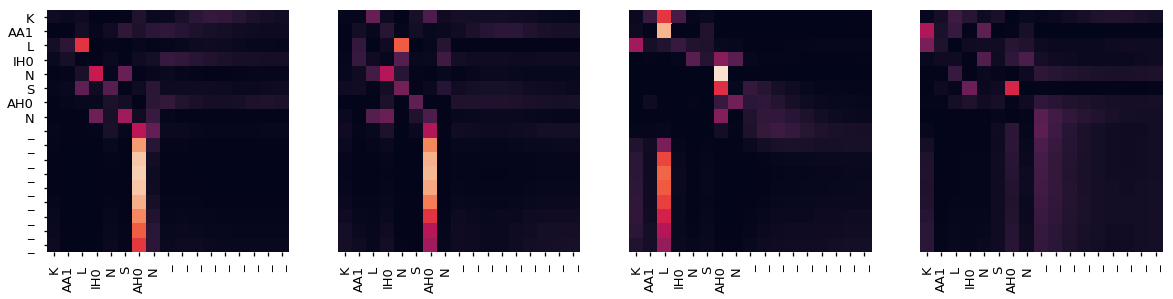

Encoder Layer 4


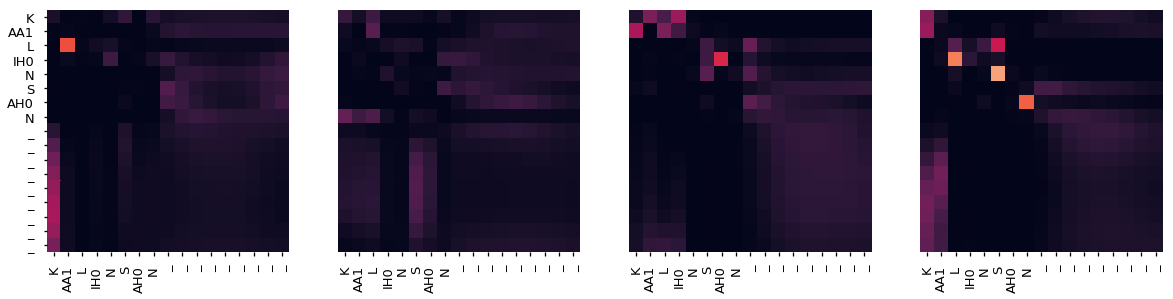

Encoder Layer 6


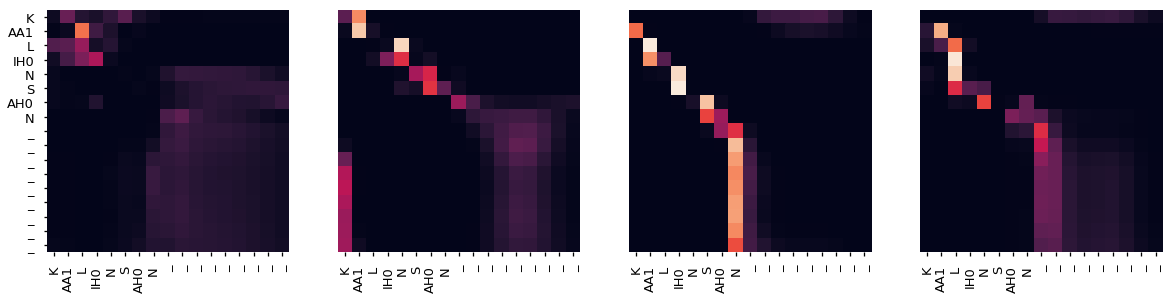

Decoder Self Layer 2


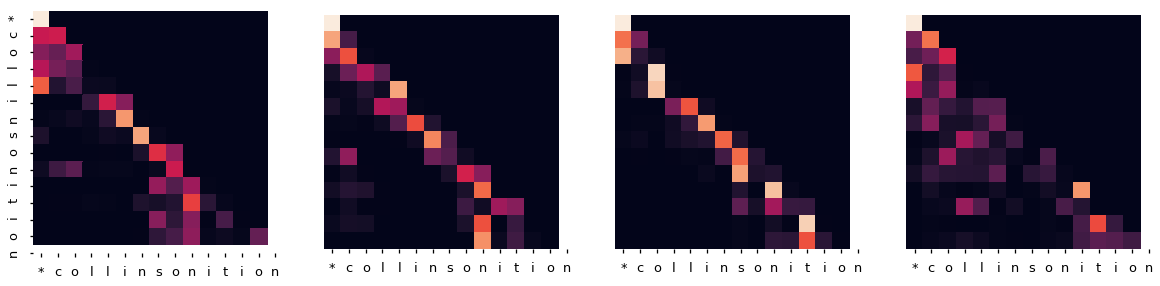

Decoder Src Layer 2


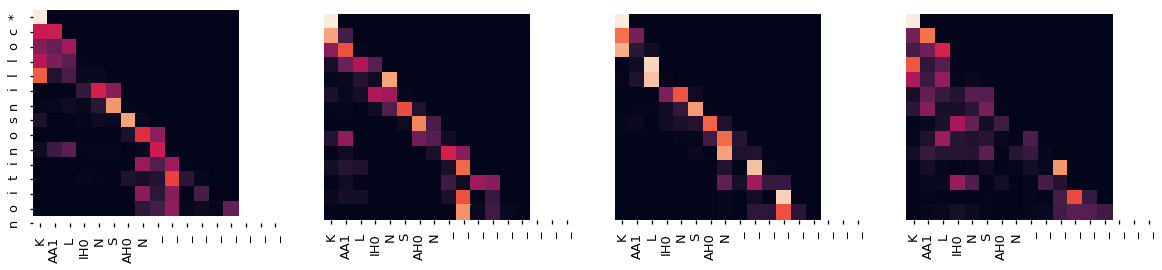

Decoder Self Layer 4


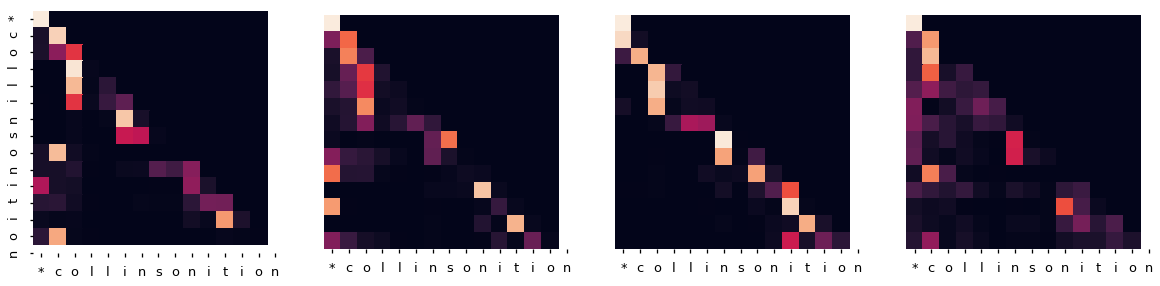

Decoder Src Layer 4


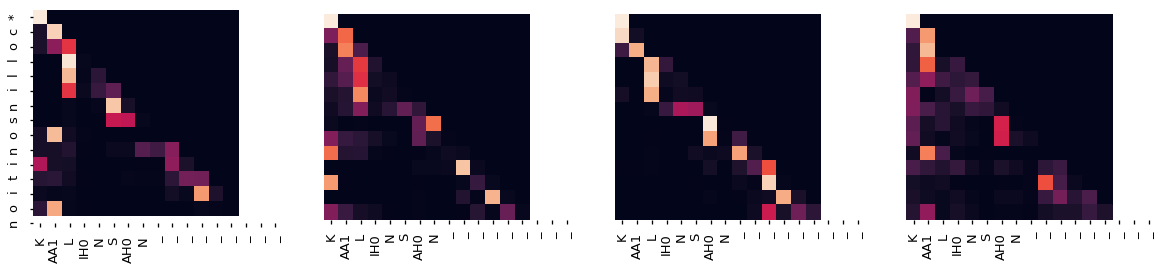

Decoder Self Layer 6


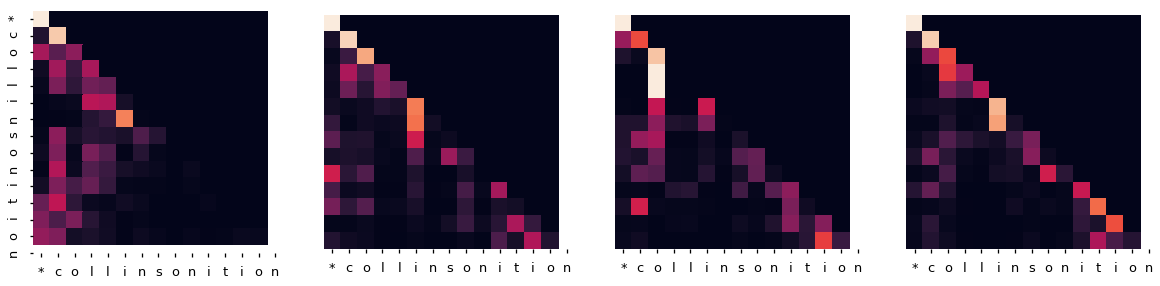

Decoder Src Layer 6


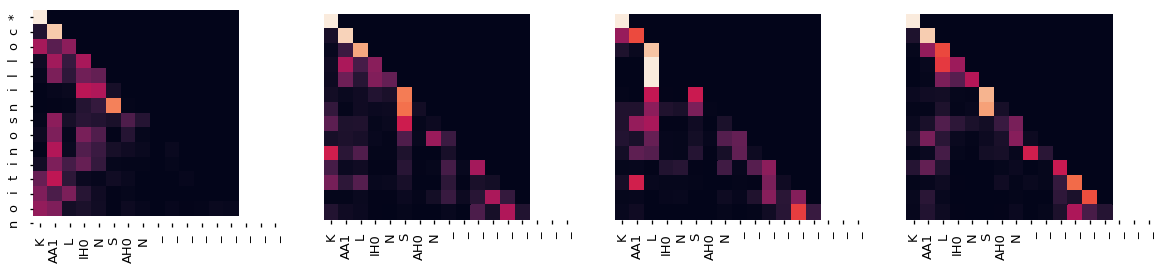

In [194]:
sent = [phonemes[p] for p in input_test[testd]]
tgt_sent = prediction
def draw(data, x, y, ax):
    seaborn.heatmap(data, 
                    xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0, 
                    cbar=False, ax=ax)
    
for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print("Encoder Layer", layer+1)
    for h in range(4):
        draw(model.encoder.layers[layer].self_attn.attn[0, h].data, 
            sent, sent if h ==0 else [], ax=axs[h])
    plt.show()
    
for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print("Decoder Self Layer", layer+1)
    for h in range(4):
        draw(model.decoder.layers[layer].self_attn.attn[0, h].data[:len(tgt_sent), :len(tgt_sent)], 
            tgt_sent, tgt_sent if h ==0 else [], ax=axs[h])
    plt.show()
    print("Decoder Src Layer", layer+1)
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    for h in range(4):
        draw(model.decoder.layers[layer].self_attn.attn[0, h].data[:len(tgt_sent), :len(sent)], 
            sent, tgt_sent if h ==0 else [], ax=axs[h])
    plt.show()
